# Time Evolution

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion, RectangleSkyRegion

from astropy.time import Time

In [2]:
#from gammapy.detect import compute_lima_on_off_image,compute_lima_image # quelle différence entre les deux ?

from gammapy.data import DataStore
from gammapy.irf import PSFKernel
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.datasets import MapDataset, Datasets, FluxPointsDataset
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    FoVBackgroundMaker,
)
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Models,
    SkyModel,
    BackgroundModel,
    PowerLawSpectralModel,
    PowerLaw2SpectralModel,
    PointSpatialModel,
    ExpCutoffPowerLawSpectralModel,
    TemplateSpatialModel,
    GaussianSpatialModel,
    FoVBackgroundModel
)
#from gammapy.stats import significance, excess # utiles ?
from gammapy.estimators import (
    #LiMaMapEstimator,
    TSMapEstimator,
    ExcessMapEstimator,
    FluxPointsEstimator
)


import gammapy
gammapy.__version__

'0.18.2'

In [3]:
src_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

In [4]:
emin, emax = [0.5, 100] * u.TeV

e_bins = 20

energy_axis = MapAxis.from_energy_bounds(
    emin.value, emax.value, e_bins, unit="TeV"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    frame="galactic",
    proj="CAR",
    axes=[energy_axis],
)

geom2d = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    frame="galactic",
    proj="CAR",
)

emintrue, emaxtrue = [0.3,200] * u.TeV
e_bins_true = 30

energy_axis_true = MapAxis.from_energy_bounds(
    emintrue.value, emaxtrue.value, e_bins_true, unit="TeV", name="energy_true"
)

In [22]:
from pathlib import Path

# Directory for outputs

path = Path("../../../hess_results/GC_variability_0.18.2/hap-hd")
path.mkdir(exist_ok=True)

pathm = Path(path/"mapdatasets")
pathm.mkdir(exist_ok=True)

pathp = Path(path/"parameter_stability")
pathp.mkdir(exist_ok=True)

pathpar = Path(pathp/"2amps_2indexes_2cutoff")
pathpar.mkdir(exist_ok=True)

# To find the model template
pathmo = Path(path/"models")
pathmo.mkdir(exist_ok=True)

model_name = pathmo/"models_template_2cutoff.yaml"

## Creating the datasets

In [23]:
datasets_year = Datasets.read(pathm/"datasets_year.yaml")

## Reading the model template

In [24]:
modelGC,modelG09, modeldiff= Models.read(model_name)

In [25]:
# if needed
modelGC.parameters["amplitude"].frozen = False
modelGC.parameters["amplitude"].value = 3.0e-12

modelGC.parameters["index"].frozen = False
modelGC.parameters["index"].value = 1.77

modelGC.spectral_model.parameters['lambda_'].frozen = False
modelGC.spectral_model.parameters['lambda_'].value = 1/5.4

modeldiff.parameters["amplitude"].frozen = False
modeldiff.parameters["amplitude"].value = 3.0e-12

modeldiff.parameters["index"].frozen = False
modeldiff.parameters["index"].value = 2.24

modeldiff.spectral_model.parameters['lambda_'].frozen = False
modeldiff.spectral_model.parameters['lambda_'].value = 0.0

## Constructing the mask

In [26]:
fit_region = RectangleSkyRegion(src_pos, 4*u.deg, 2*u.deg)

J1745_303_region = CircleSkyRegion(SkyCoord(358.6,  -0.6, unit="deg", frame="galactic"), 0.5 * u.deg)

fit_mask = geom.region_mask([fit_region])*geom.region_mask([J1745_303_region] , inside=False)

fit_mask = Map.from_geom(geom, data=fit_mask)

## Applying the mask and the model template

In [27]:
for year in range(2004,2020):
    datasets_year[f'map_{year}'].fit_mask = fit_mask
    bkg_model = FoVBackgroundModel(dataset_name=f"map_{year}")
    datasets_year[f'map_{year}'].models =  [modelGC.copy(),modelG09.copy(),modeldiff.copy(),bkg_model]

# Fitting the datasets

In [28]:
def fit_dataset(mapdataset):
    fit = Fit([mapdataset])
    result = fit.run()
    
    table = result.parameters.to_table()
    
    #cov = result.parameters.covariance
    
    return table, result# , cov

In [29]:
%%time

results_per_year = dict()
results = []
cov_per_year = dict()

for year in range(2004,2020):
    
    table, result = fit_dataset(datasets_year[f"map_{year}"])
    
    results.append(result)
    
    results_per_year[year] = table

HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found


CPU times: user 13min 54s, sys: 1min 18s, total: 15min 12s
Wall time: 15min 13s


In [30]:
years = []
for year in range(2004,2020):
    if results[year-2004].message =='Optimization terminated successfully.':
        years.append(year)

# Extracting parameters (only one cell to run)

In [31]:
# Spectral models with 2 cutoffs (both indexes unfrozen)

indexGC = []
indexGC_err = []
ampsGC = []
ampsGC_err = []
lambdaGC = []
lambdaGC_err = []

indexdiff = []
indexdiff_err = []
ampsdiff = []
ampsdiff_err = []
lambdadiff = []
lambdadiff_err = []

norms = []
norms_err = []


for year in years:
    modelGC = datasets_year[f'map_{year}'].models[0].spectral_model
    modeldiff = datasets_year[f'map_{year}'].models[2].spectral_model
    
    indexGC.append(modelGC.index.value)
    indexGC_err.append(modelGC.index.error)
    ampsGC.append(modelGC.amplitude.value)
    ampsGC_err.append(modelGC.amplitude.error)
    lambdaGC.append(modelGC.lambda_.value)
    lambdaGC_err.append(modelGC.lambda_.error)
    
    indexdiff.append(modeldiff.index.value)
    indexdiff_err.append(modeldiff.index.error)    
    ampsdiff.append(modeldiff.amplitude.value)
    ampsdiff_err.append(modeldiff.amplitude.error)
    lambdadiff.append(modeldiff.lambda_.value)
    lambdadiff_err.append(modeldiff.lambda_.error)
   
    #norms.append(results_per_year[year]['value'][18])
    #norms_err.append(results_per_year[year]['error'][18])

# Saving the results

## Fitting a time evolution model

In [32]:
import scipy.stats as stats

from astropy.modeling import models, fitting

from scipy.stats import chisquare, chi2

# chi2 non réduit
def chisq(obs, exp, error):
    chisq = 0
    for i in range(len(obs)):
        chisq = chisq + ((obs[i]-exp)**2)/(error[i]**2)
    return chisq

# chi2 réduit
def chisqr(obs, exp, error):
    chisqr = 0
    for i in range(len(obs)):
        chisqr = chisqr + ((obs[i]-exp)**2)/(error[i]**2)
    return chisqr/(len(obs) -1)

def pval(obs, exp, error, nddl): # number of DoF is the number of points minus number of fitted parameters (1 for a constant)
    chisq = 0
    for i in range(len(obs)):
        chisq = chisq + ((obs[i]-exp)**2)/(error[i]**2)
    pval = 1 - chi2.cdf(chisq, nddl)
    return pval

## Displaying parameters evolution

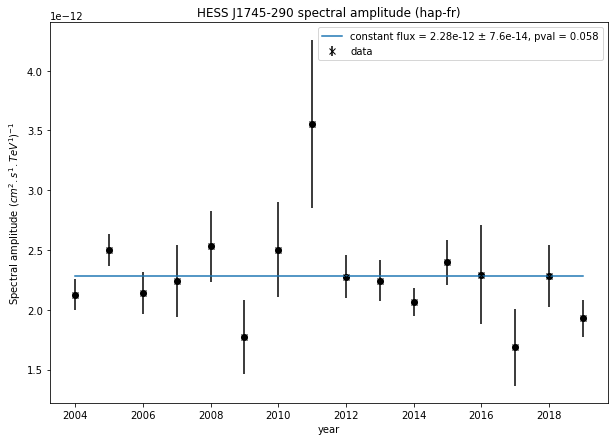

In [33]:
x = years
y = ampsGC
y_uncs = ampsGC_err

# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(1e-12)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y) #, weights=1.0/y_uncs)

# évaluation du chi2 réduit
A1 = y
A2 = t(2004)
err_bars = y_uncs

pv = pval(A1, A2, err_bars, len(A1)-1)
error_const = np.sqrt(sum([a**2 for a in err_bars]))/len(A1)

# Plot the data with the best-fit model
plt.figure(figsize=(10,7))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="data")
plt.plot(x, t(x), label=f"constant flux = {A2:0.2e} ± {error_const:0.1e}, pval = {pv:0.3f}")
plt.xlabel('year')
plt.ylabel(r'Spectral amplitude $(cm^2.s^1.TeV^1)^{-1}$')
plt.legend(loc=1)
plt.title("HESS J1745-290 spectral amplitude (hap-fr)")
plt.savefig(pathpar/"ampGC_hd.pdf")

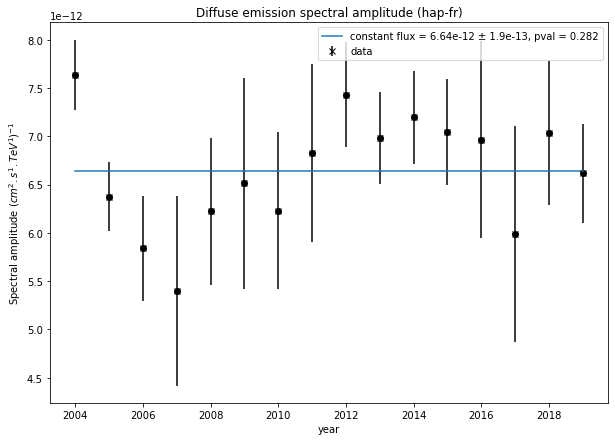

In [34]:
x = years
y = ampsdiff
y_uncs = ampsdiff_err

# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(1)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y) #, weights=1.0/y_uncs)

# évaluation du chi2 réduit
A1 = y
A2 = t(2004)
err_bars = y_uncs

pv = pval(A1, A2, err_bars, len(A1)-1)
error_const = np.sqrt(sum([a**2 for a in err_bars]))/len(A1)

# Plot the data with the best-fit model
plt.figure(figsize=(10,7))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="data")
plt.plot(x, t(x), label=f"constant flux = {A2:0.2e} ± {error_const:0.1e}, pval = {pv:0.3f}")
plt.xlabel('year')
plt.ylabel(r'Spectral amplitude $(cm^2.s^1.TeV^1)^{-1}$')
plt.legend(loc=1)
plt.title("Diffuse emission spectral amplitude (hap-fr)")
plt.savefig(pathpar/"ampdiff_hd.pdf")

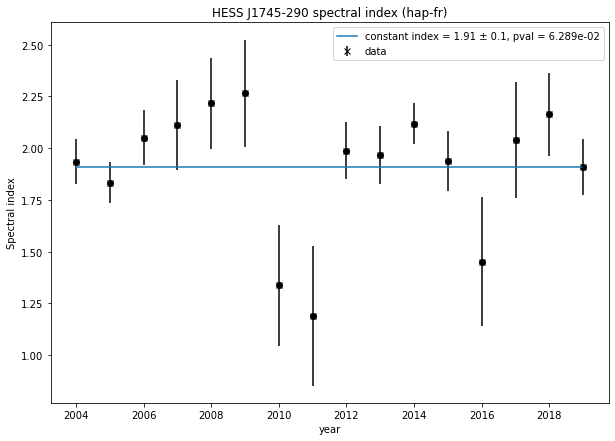

In [35]:
x = years
y = indexGC
y_uncs = indexGC_err

# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(1)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y) #, weights=1.0/y_uncs)

# évaluation du chi2 réduit
A1 = y
A2 = t(2004)
err_bars = y_uncs

pv = pval(A1, A2, err_bars, len(A1)-1)
error_const = np.sqrt(sum([a**2 for a in err_bars]))/len(A1)

# Plot the data with the best-fit model
plt.figure(figsize=(10,7))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="data")
plt.plot(x, t(x), label=f"constant index = {A2:0.2f} ± {error_const:0.1f}, pval = {pv:0.3e}")
plt.xlabel('year')
plt.ylabel('Spectral index')
plt.legend(loc=1)
plt.title("HESS J1745-290 spectral index (hap-fr)")
plt.savefig(pathpar/"index_GC_hd.pdf")

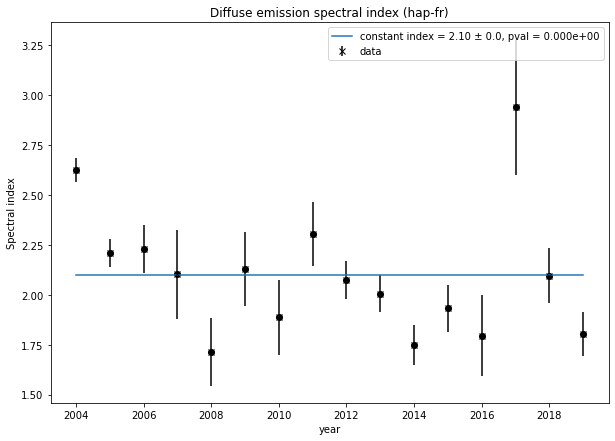

In [36]:
x = years
y = indexdiff
y_uncs = indexdiff_err

# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(1)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y) #, weights=1.0/y_uncs)

# évaluation du chi2 réduit
A1 = y
A2 = t(2004)
err_bars = y_uncs

pv = pval(A1, A2, err_bars, len(A1)-1)
error_const = np.sqrt(sum([a**2 for a in err_bars]))/len(A1)

# Plot the data with the best-fit model
plt.figure(figsize=(10,7))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="data")
plt.plot(x, t(x), label=f"constant index = {A2:0.2f} ± {error_const:0.1f}, pval = {pv:0.3e}")
plt.xlabel('year')
plt.ylabel('Spectral index')
plt.legend(loc=1)
plt.title("Diffuse emission spectral index (hap-fr)")
plt.savefig(pathpar/"index_diff_hd.pdf")

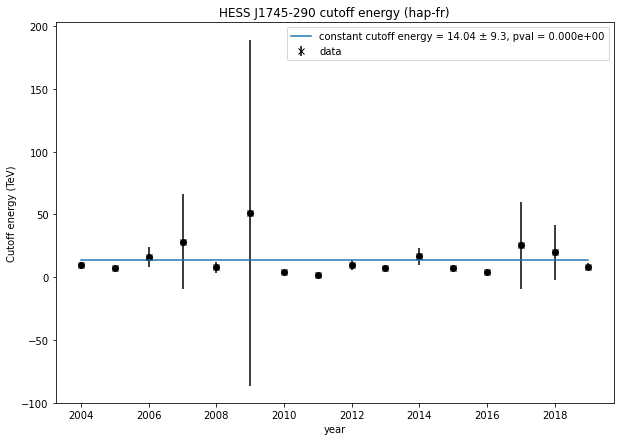

In [37]:
x = years
y = 1/np.array(lambdaGC)
y_uncs = y*(np.array(lambdaGC_err)/np.array(lambdaGC))

# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(10)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y) #, weights=1.0/y_uncs)

# évaluation du chi2 réduit
A1 = y
A2 = t(2004)
err_bars = y_uncs

pv = pval(A1, A2, err_bars, len(A1)-1)
error_const = np.sqrt(sum([a**2 for a in err_bars]))/len(A1)

# Plot the data with the best-fit model
plt.figure(figsize=(10,7))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="data")
plt.plot(x, t(x), label=f"constant cutoff energy = {A2:0.2f} ± {error_const:0.1f}, pval = {pv:0.3e}")
plt.xlabel('year')
plt.ylabel('Cutoff energy (TeV)')
plt.legend(loc=1)
plt.title("HESS J1745-290 cutoff energy (hap-fr)")
plt.savefig(pathpar/"cutoff_GC_hd.pdf")

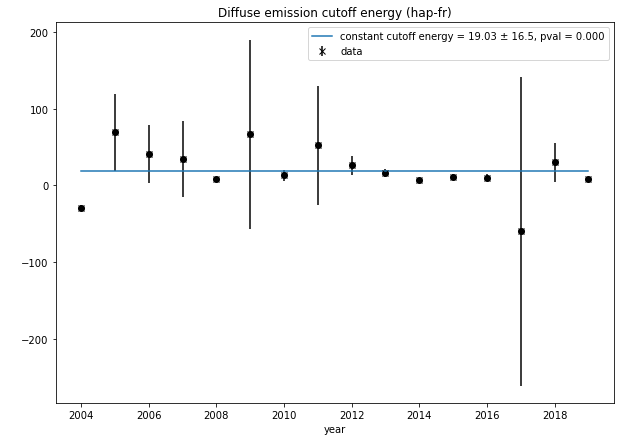

In [38]:
x = years
y = 1/np.array(lambdadiff)
y_uncs = y*(np.array(lambdadiff_err)/np.array(lambdadiff))

# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(10)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y) #, weights=1.0/y_uncs)

# évaluation du chi2 réduit
A1 = y
A2 = t(2004)
err_bars = y_uncs

pv = pval(A1, A2, err_bars, len(A1)-1)
error_const = np.sqrt(sum([a**2 for a in err_bars]))/len(A1)

# Plot the data with the best-fit model
plt.figure(figsize=(10,7))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="data")
plt.plot(x, t(x), label=f"constant cutoff energy = {A2:0.2f} ± {error_const:0.1f}, pval = {pv:0.3f}")
plt.xlabel('year')
plt.ylabel(' ')
plt.legend(loc=1)
plt.title("Diffuse emission cutoff energy (hap-fr)")
plt.savefig(pathpar/"cutoff_DE_hd.pdf")